In [1]:
display(HTML("<style>.rendered_html.text_cell_render {max-width:500px; }</style>"));

HTML{String}("<style>.rendered_html.text_cell_render {max-width:500px; }</style>")

In [2]:
#nbx --fname="src/two_d_three_p.jl"
using BenchmarkTools
using Colors, Plots
col = palette(:default);

# 2D3P likelihood

In [3]:
# Todo: collect these helper somewhere
# Done: moved them to MyUtils.jl
"""Stacks vectors on top each other (along dim 1)"""
function stack(xs::AbstractVector) return reduce(vcat,transpose.(xs)) end
"""Stacks vectors horizontally (along dim 2)"""
function hstack(xs::AbstractVector) return reduce(hcat,xs) end
 
polar_inv(zs::Vector{Float64}, as::Vector{Float64}) = [[z*cos(a);z*sin(a)] for (z,a) in zip(zs,as)];

## CPU Baseline

Compute the intersection of two lines by solving: $x + s \cdot dx = y + t \cdot dy$.

Implementation from my `Geometry.jl` package:

```julia
function line_intersect(x, x′, y, y′)
    dx = x′ - x
    dy = y′ - y
    if det([-dx dy]) == 0
        return [Inf;Inf]
    end
    s, t = inv([-dx dy])*(x - y)
    return s,t
end;
```

In [4]:
function cast_cpu!(X, A, p, Z)    
    
    for i = 1:size(X,1), j = 1:size(A,1)
        
        x1, x2 = X[i,1], X[i,2]
        y1, y2 = p[1], p[2]
        v1 = (x1 - y1)
        v2 = (x2 - y2)
        
        dx1, dx2 = X[i,3] - X[i,1], X[i,4] - X[i,2]
        dy1, dy2 = cos(A[j]+p[3]), sin(A[j] + p[3])
        
        a, b = -dx1, dy1
        c, d = -dx2, dy2
        det = a*d - c*b
        if det != 0
            s = 1/det*(  d*v1 - b*v2)
            t = 1/det*(- c*v1 + a*v2)
            if t >= 0 && 0 <= s && s <= 1
                @inbounds Z[j] = min(t,Z[j])
            end
        end
    end
    return
end

function bench_cast_cpu!(X,A,p,Y)
    cast_cpu!(X,A,p,Y)
end

bench_cast_cpu! (generic function with 1 method)

## Likelihood

In [63]:
function logsumexp(a::AbstractArray{<:Real}; dims)
    m = maximum(a; dims=dims)
    return m + log.(sum(exp.(a .- m); dims=dims))
end

logsumexp (generic function with 1 method)

In [5]:
using JSON

fname = "./data/data_3.json"
d = JSON.parsefile(fname)

_segs = Array{Float64}.(d["env"]["segs"]);
_xs   = Array{Float64}.(d["motion"]["x"]);
_hds  = Array{Float64}(d["motion"]["hd"]);

_a    = Array{Float64}(d["sensor"]["a"]);
_zs   = Array{Float64}.(d["sensor"]["z"]);
_zmax = d["sensor"]["zmax"];

In [6]:
using Gen

In [478]:
push!(LOAD_PATH, "../../Gen-Distribution-Zoo/src")
using GenDistributionZoo: ProductDistribution, diagnormal

mvuniform = ProductDistribution(uniform)

GenDistributionZoo.HomogeneousProduct{Float64}(Gen.UniformContinuous(), 1)

In [337]:
t = 10

z = _zs[t]
w = 3
y = stack(polar_inv(z,_a));
x = rand(n,2)
n = length(_a)
size(x), size(y)

((361, 2), (361, 2))

In [356]:
w = 10
r = 2*w+1
std = 1


1

In [342]:
function full_mixture_logpdf(x, y, std)
    n = size(x,1)
    
    log_p = logpdf.([normal], reshape(x, n,1,2), reshape(y, 1,n,2), std*ones(1,n,2))
    log_p = sum(log_p, dims=3)
    log_p = logsumexp(log_p .- log(n), dims=2)
    log_p = sum(log_p, dims=1)
    
    return log_p[1,1,1]
end

full_mixture_logpdf (generic function with 2 methods)

In [343]:
function ddppp_logpdf(x, y, std, w)
    
    r = 2*w+1
    n = size(x,1)
    
    X  = repeat(reshape(x', 2,1,n), 1,r,1);    
    S  = repeat(std*ones(2,1,n),   1,r,1);
    Y′ = [reshape(circshift(y, i)', 2,1,n) for i=-w:w];
    Y  = reduce(hcat, Y′);
    
    log_p = reshape(logpdf.([normal], X, Y, S), 2, r, n)
    log_p = sum(log_p, dims=1)
    log_p = logsumexp(log_p .- log(r), dims=2)
    log_p = sum(log_p, dims=3)
    
    return log_p[1,1,1]
end

ddppp_logpdf (generic function with 1 method)

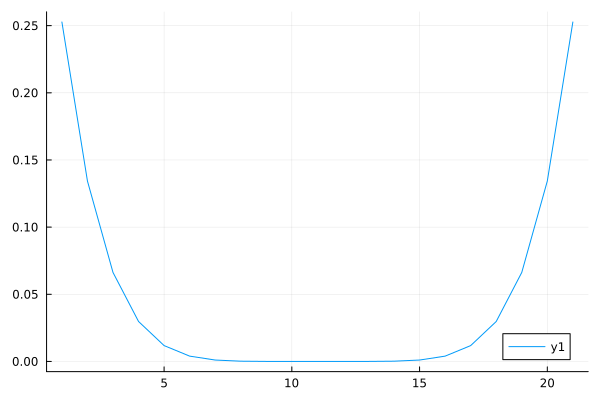

In [1004]:
mix = 0.1 .+ abs.(range(-w, w, r)).^6
mix = mix/sum(mix)
plot(mix)

In [1006]:
function ddppp_v2_logpdf(x, y, std, w)
    
    r = 2*w+1
    n = size(x,1)
    
    X  = repeat(reshape(x', 2,1,n), 1,r,1);    


    S  = repeat(std*ones(2,1,n),   1,r,1);
    
    Y′ = [reshape(circshift(y, i)', 2,1,n) for i=-w:w];
    Y  = reduce(hcat, Y′);

    mix = 0.1 .+ abs.(range(-w, w, r)).^6
    mix = mix/sum(mix)
    
    log_p = reshape(logpdf.([normal], X, Y, S), 2, r, n)
    log_p = sum(log_p, dims=1) .- reshape(log.(mix), 1, r, 1)
    log_p = logsumexp(log_p, dims=2)
    log_p = sum(log_p, dims=3)
    
    return log_p[1,1,1]
end

ddppp_v2_logpdf (generic function with 1 method)

In [ ]:
function ddppp_v3_logpdf(x, y, std, w)
    
    r = 2*w+1
    n = size(x,1)
    
    X  = repeat(reshape(x', 2,1,n), 1,r,1);    

    sigs = 1 .+ abs.(range(-1, 1, r))
    S  = std*repeat(sigs',   2,1,n)
    
    Y′ = [reshape(circshift(y, i)', 2,1,n) for i=-w:w];
    Y  = reduce(hcat, Y′);
    
    log_p = reshape(logpdf.([normal], X, Y, S), 2, r, n)
    log_p = sum(log_p, dims=1)
    log_p = logsumexp(log_p .- log(r), dims=2)
    log_p = sum(log_p, dims=3)
    
    return log_p[1,1,1]
end

In [882]:
full_mixture_logpdf(x, y, std),
ddppp_logpdf(x, y, std, 180),
ddppp_v2_logpdf(x, y, std, 180)

(-7325.397419694713, -7325.397419694713, -5200.209994708678)

In [357]:
@btime ddppp_logpdf( x,  y,  std,  w) samples=3 evals=3;
@btime ddppp_logpdf($x, $y, $std, $w) samples=3 evals=3;
ddppp_logpdf(x, y, std, w)

  2.126 ms (455 allocations: 1.95 MiB)
  1.778 ms (454 allocations: 1.95 MiB)


-1281.106293582663

In [358]:
W = ones(r,n)/r
Y′ = [reshape(circshift(y, i)', 2,1,n) for i=-w:w];
Y  = reduce(hcat, Y′);
S  = repeat(std*ones(2,1,n),   1,r,1);
sensor_mix  = HomogeneousMixture(diagnormal, [1,1])
sensor_dist = ProductDistribution(sensor_mix, -1)
logpdf(sensor_dist, x', W, Y, S),
ddppp_logpdf(x, y, std, w)

(-1281.106293582663, -1281.106293582663)

In [359]:
@btime logpdf($sensor_dist, $(x'), $W, $Y, $S) samples=3 evals=3;

  9.733 ms (154878 allocations: 5.36 MiB)


## Experiment

In [399]:
push!(LOAD_PATH, "src");
using MyUtils

[ Info: Precompiling MyUtils [top-level]


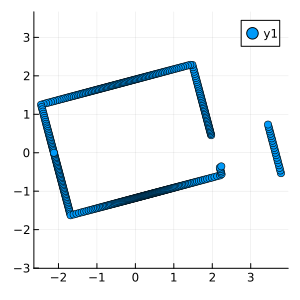

In [388]:
t = 4
x0 = _xs[t]
hd0 = _hds[t]
p0 = [x0;hd0]
z0 = _zmax*ones(length(_a))
cast_cpu!(stack(_segs), _a, p0, z0)  
y = stack(polar_inv(z0, _a));
# ------------------------
plot(size=(300,300), aspect_ratio=:equal)
scatter!(y[:,1],y[:,2])

In [603]:
Y = []
P = []
for i=1:1_000
#     x  = diagnormal(x0, 0.5*ones(2))
    delta = 1.
    x  = mvuniform([x0[1] - delta,x0[2] - delta], [x0[1] + delta,x0[2] + delta])
#     x = x0
    hd = normal(hd0, 10/360*2π)
    p = [x;hd0] 
    push!(P,p)
    z = _zmax*ones(length(_a))
    cast_cpu!(stack(_segs), _a, p, z)  
    y = stack(polar_inv(z, _a));
    push!(Y,y)
end

x = stack(polar_inv(z0, _a));


-34022.49786512667  ,  963.0254141295868


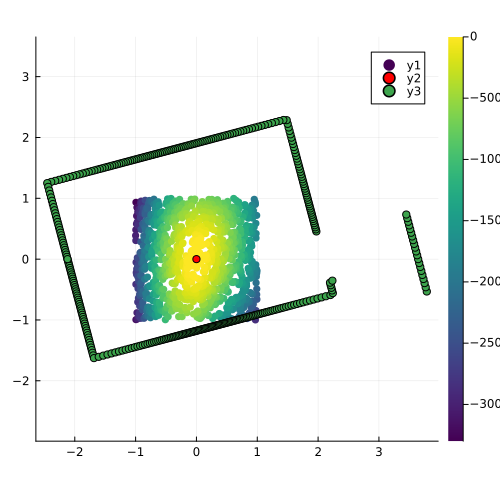

In [604]:
w = 1
L1 = [ ddppp_logpdf(x,y,0.1,w) for y in Y ];
perm = sortperm(L1)
println(minimum(L1), "  ,  ", maximum(L1))
# ------------------------
plot(size=(500,500), aspect_ratio=:equal)
scatter!([p[1:2]-x0 for p in P[perm]], zcolor=L1[perm], clim=(-33000,0), color=:viridis, markerstrokewidth=0)
scatter!([zeros(2)], c=:red)
scatter!(x[:,1],x[:,2])

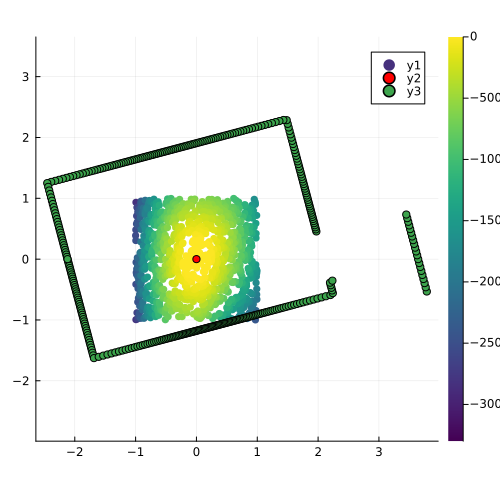

In [605]:
w = 5
L5 = [ ddppp_logpdf(x,y,0.1,w) for y in Y ];
perm = sortperm(L5)
# ------------------------
plot(size=(500,500), aspect_ratio=:equal)
scatter!([p[1:2]-x0 for p in P[perm]], zcolor=L5[perm], clim=(-33000,0), color=:viridis, markerstrokewidth=0)
scatter!([zeros(2)], c=:red)
scatter!(x[:,1],x[:,2])

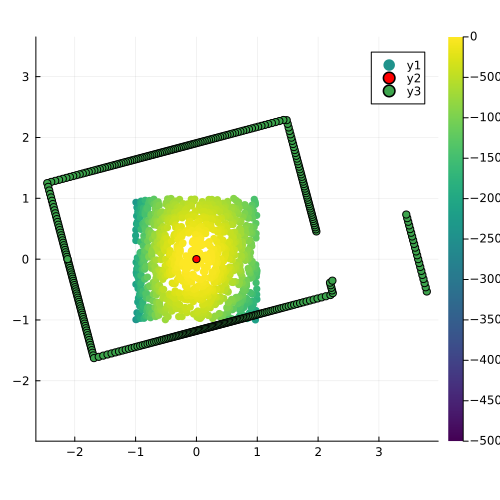

In [606]:
w = 10
L10 = [ ddppp_logpdf(x,y,0.1,w) for y in Y ];
perm = sortperm(L10)
# ------------------------
plot(size=(500,500), aspect_ratio=:equal)
scatter!([p[1:2]-x0 for p in P[perm]], zcolor=L10[perm], clim=(-50000,0), color=:viridis, markerstrokewidth=0)
scatter!([zeros(2)], c=:red)
scatter!(x[:,1],x[:,2])

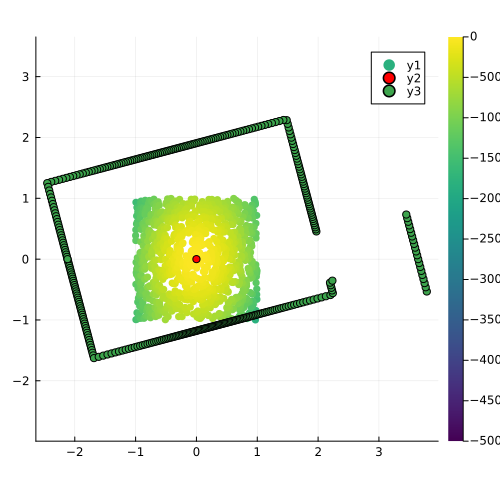

In [607]:
w = 50
L50 = [ ddppp_logpdf(x,y,0.1,w) for y in Y ];
perm = sortperm(L50)
# ------------------------
plot(size=(500,500), aspect_ratio=:equal)
scatter!([p[1:2]-x0 for p in P[perm]], zcolor=L50[perm], clim=(-50000,0),color=:viridis, markerstrokewidth=0)
scatter!([zeros(2)], c=:red)
scatter!(x[:,1],x[:,2])

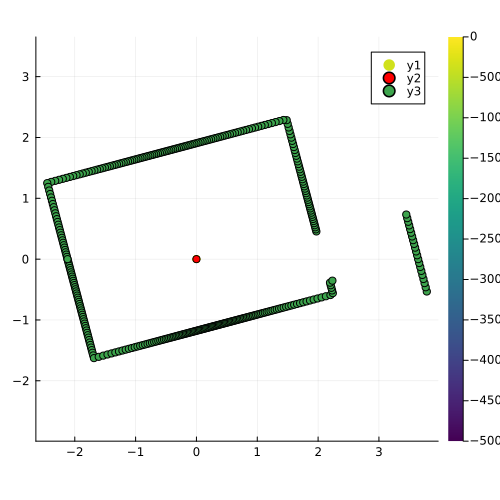

In [582]:
w = 100
L100 = [ ddppp_logpdf(x,y,0.1,w) for y in Y ];
perm = sortperm(L100)
# ------------------------
plot(size=(500,500), aspect_ratio=:equal)
scatter!([p[1:2]-x0 for p in P[perm]], zcolor=L100[perm], clim=(-50000,0), color=:viridis, markerstrokewidth=0)
scatter!([zeros(2)], c=:red)
scatter!(x[:,1],x[:,2])

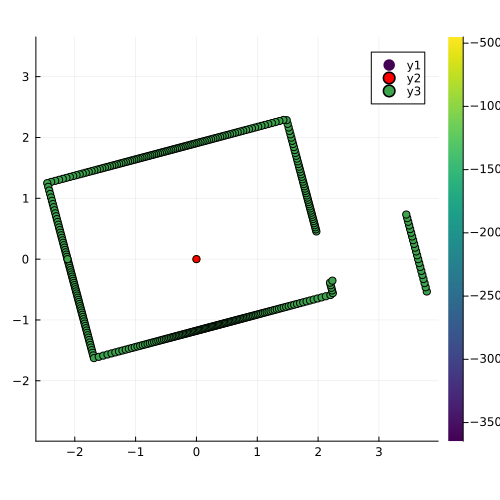

In [583]:
Lfull = [ full_mixture_logpdf(x,y,0.1) for y in Y ];
perm = sortperm(Lfull)
# ------------------------
plot(size=(500,500), aspect_ratio=:equal)
scatter!([p[1:2]-x0 for p in P[perm]], zcolor=Lfull[perm], color=:viridis, markerstrokewidth=0)
scatter!([zeros(2)], c=:red)

scatter!(x[:,1],x[:,2])

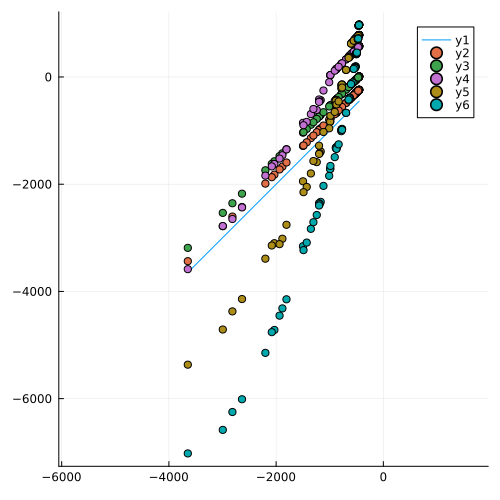

In [584]:
plot(size=(500,500), aspect_ratio=:equal)
plot!([[minimum(Lfull);minimum(Lfull)],[maximum(Lfull);maximum(Lfull)]], c=col[1])
# scatter!(Lfull,Lfull)
scatter!(Lfull,L100)
scatter!(Lfull,L50)
scatter!(Lfull,L10)
scatter!(Lfull,L5)
scatter!(Lfull,L1)



# plot!(L1 - L5)
# plot!(L1 - L10)
# plot!(L50)

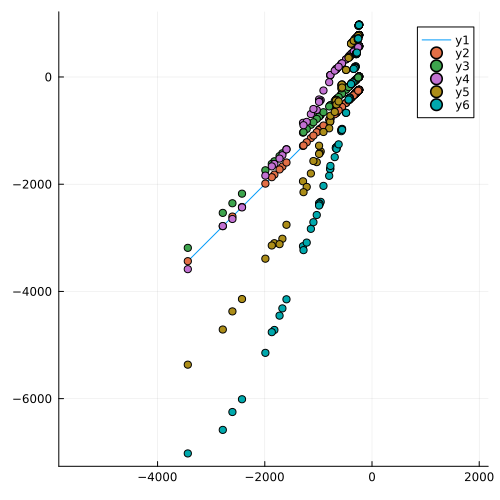

In [585]:
Lbase = L100

plot(size=(500,500), aspect_ratio=:equal)
plot!([[minimum(Lbase);minimum(Lbase)],[maximum(Lbase);maximum(Lbase)]], c=col[1])
scatter!(Lbase,L100)
scatter!(Lbase,L50)
scatter!(Lbase,L10)
scatter!(Lbase,L5)
scatter!(Lbase,L1)



# plot!(L1 - L5)
# plot!(L1 - L10)
# plot!(L50)

In [586]:
using LinearAlgebra: norm

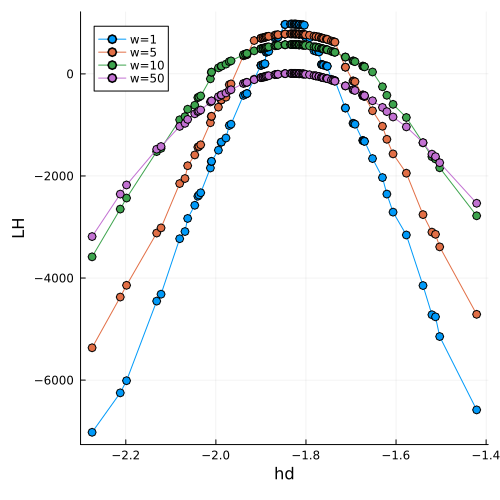

In [600]:
Lbase = L100



phd = [p[3] for p in P]
perm = sortperm(phd)

plot(size=(500,500), xlabel="hd", ylabel="LH")
plot!(phd[perm],  L1[perm], marker=:o, label="w=1")
plot!(phd[perm],  L5[perm], marker=:o, label="w=5")
plot!(phd[perm], L10[perm], marker=:o, label="w=10")
plot!(phd[perm], L50[perm], marker=:o, label="w=50")


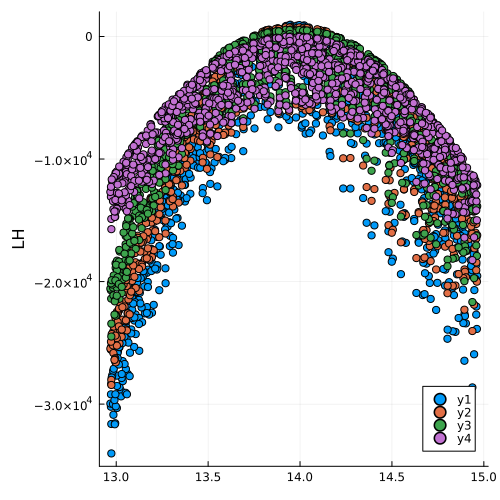

In [627]:
Lbase = L100



px = [p[1] for p in P]
py = [p[2] for p in P]
perm = sortperm(pn)

plot(size=(500,500), ylabel="LH")
scatter!(px,L1)
scatter!(px,L5)
scatter!(px,L10)
scatter!(px,L50)

## Experiment

Good t's:
```julia
t = 3
t = 7
t = 13
t = 23
```

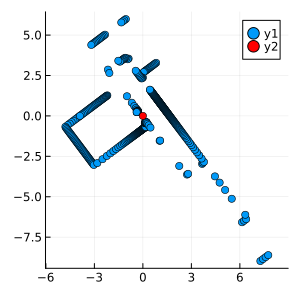

In [1007]:
t = 7
x0 = _xs[t]
hd0 = _hds[t]
p0 = [x0;hd0]
z0 = _zmax*ones(length(_a))
cast_cpu!(stack(_segs), _a, p0, z0)  
y = stack(polar_inv(z0, _a));
# ------------------------
plot(size=(300,300), aspect_ratio=:equal)
scatter!(y[:,1],y[:,2])
scatter!([zeros(2)], c=:red)

In [1008]:
Y = []
P = []

delta_x = 0.
delta_hd =  45/360*2π
for i=1:200
    x  = mvuniform([x0[1] - delta_x,x0[2] - delta_x], [x0[1] + delta_x,x0[2] + delta_x])
    hd = uniform(hd0 - delta_hd, hd0 + delta_hd)
    p = [x;hd] 
    push!(P,p)
    z = _zmax*ones(length(_a))
    cast_cpu!(stack(_segs), _a, p, z)  
    y = stack(polar_inv(z, _a));
    push!(Y,y)
end

x = stack(polar_inv(z0, _a));

In [1009]:
std = 0.1
L = Dict()
L2 = Dict()
ws = [1,5,10,20]
for w in ws
    L[w] = [  ddppp_logpdf(x,y,std,w) for y in Y ];
    L2[w] = [ ddppp_v2_logpdf(x,y,std,w) for y in Y ];
#     L[w] = [ ddppp_v3_logpdf(x,y,std,w) for y in Y ];
    println(w)
end

1
5
10
20


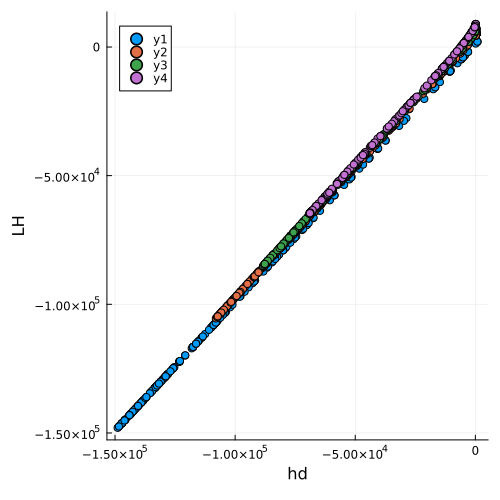

In [1010]:
phd = [p[3]-hd0 for p in P]
perm = sortperm(phd)

myplot = plot(size=(500,500), xlabel="hd", ylabel="LH")
for w in ws
    ell = L[w]
#     plot!(phd[perm], ell[perm], marker=:o, label="w=$(w)")
    scatter!(L[w],L2[w])
end
myplot

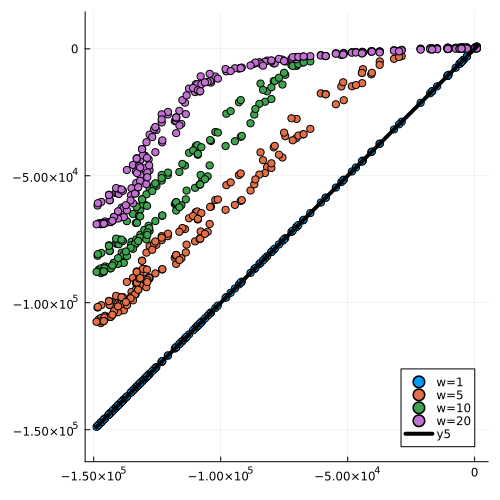

In [1011]:
Lbase = L[ws[1]]

myplot = plot(size=(500,500), aspect_ratio=:equal)

for w in ws
    ell = L[w]
    scatter!(Lbase, ell, label="w=$(w)")
end
plot!([[minimum(Lbase);minimum(Lbase)],[maximum(Lbase);maximum(Lbase)]], c=:black, linewidth=4)
myplot

-14796.50933648365
1813.0533758442073


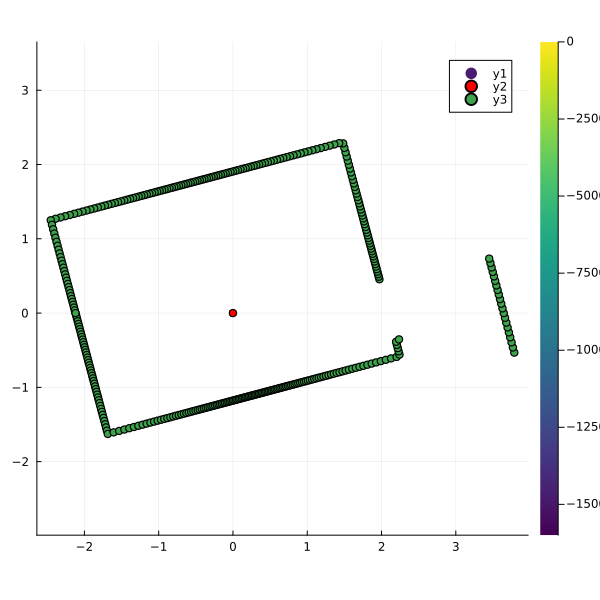

-12026.666569820207
2572.562617352756


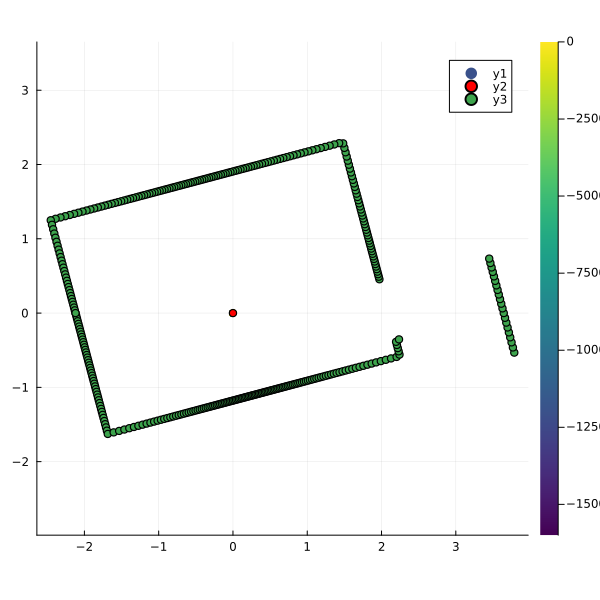

-9726.17876838775
2861.542476074433


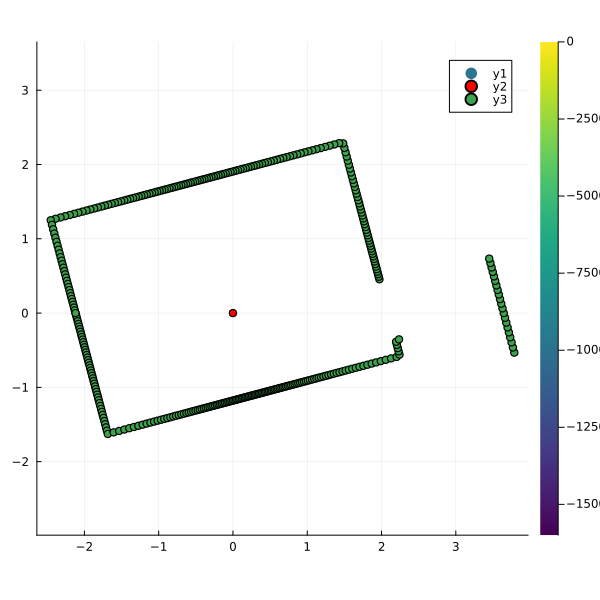

-8690.511003434625
3129.9844099466113


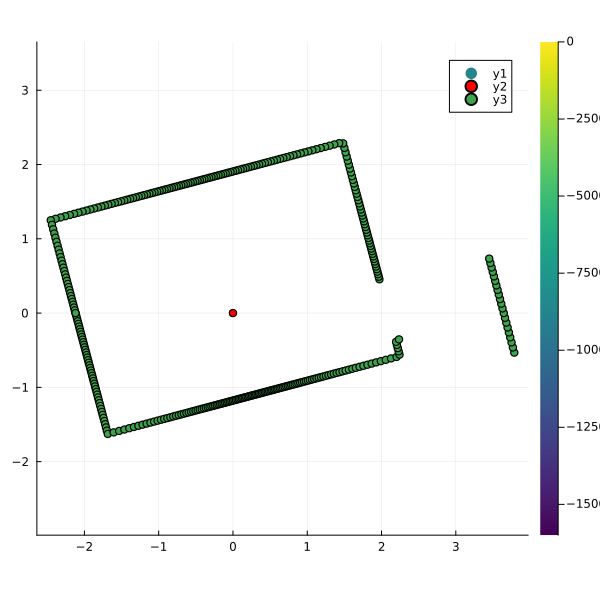

In [910]:
phd = [p[3]-hd0 for p in P]
perm = sortperm(phd)

for w in ws
    ell = L[w]
    perm = sortperm(ell)
    println(minimum(ell))
    println(maximum(ell))
    # ------------------------
    myplot = plot(size=(600,600), aspect_ratio=:equal)
    scatter!([p[1:2]-x0 for p in P[perm]], zcolor=ell[perm], clim=(-16000,0), color=:viridis, markerstrokewidth=0)
    scatter!([zeros(2)], c=:red)
    scatter!(x[:,1],x[:,2])
    display(myplot)
end
